In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import sys

sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang")

In [3]:
import ebb

ebb.__file__

'/Users/flynnwang/repo/flynn/eco_bang_bang/ebb/__init__.py'

In [4]:
import torch

from ebb.env.luxenv import get_ob_sapce
from ebb.model import _create_model, RewardSpec

reward_spec = RewardSpec(
        reward_min=-5,
        reward_max=+5,
        zero_sum=False,
    )

reward_shaping_params = dict(
  new_observed_down_tri=0.0001,
  match_observed=0,
  match_win=1,
  use_hidden_relic_estimator=True,
  energy_cost_change=0.001,                             
)

obs_space_kwargs = {
    'use_energy_cost_map': True,
    'use_single_player': False,
    "use_agent": False,
}

# Load model

In [5]:
# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_2025026_imitation_r0/011321856_weights.pt"
# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250207_behaviour_cloning_test_run_v4/000161856_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250208_behaviour_cloning_r0_with_drift_estimation_cont3/027721664_weights.pt"

# model_path = "/Users/flynnwang/repo/flynn/runs/new_md/run_20250210_post_training_full_kl_and_entropy_r0/028716800_weights.pt"

model_path = "/Users/flynnwang/repo/flynn/runs/mds/submits/run_20250211_post_training_game_win_loss_cont_r2/069065216_weights.pt"

ob_space = get_ob_sapce(obs_space_kwargs)
model = _create_model(ob_space, reward_spec=reward_spec, n_blocks=8, hidden_dim=128, base_out_channels=128,
                      embedding_dim=16, kernel_size=5, use_separate_base=False)


checkpoint_state = torch.load(model_path, map_location=torch.device("cpu"), weights_only=True)
model.load_state_dict(checkpoint_state["model_state_dict"])

<All keys matched successfully>

# Model Run

In [6]:
from luxai_s3.params import EnvParams

from luxai_s3.wrappers import LuxAIS3GymEnv, RecordEpisode
from ebb.env.luxenv import LuxS3Env
from ebb.env.wrappers import VecEnv, PytorchEnv, DictEnv
from ebb.torchbeast.core.selfplay import split_env_output_by_player, pair_env_output_for_players


def actor_model_apply(env_output, sample=True):
  lef_env_out, rig_env_out = split_env_output_by_player(env_output)
  lef_agent_out = actor_model(lef_env_out, sample=sample, probs_output=True)
  rig_agent_out = actor_model(rig_env_out, sample=sample, probs_output=True)
  return [(lef_env_out, lef_agent_out), (rig_env_out, rig_agent_out)]

def get_merged_actions(env_agent_out):
  lef_actions = env_agent_out[0][1]['actions']
  rig_actions = env_agent_out[1][1]['actions']
  return pair_env_output_for_players(lef_actions, rig_actions)

class AgentStats:

    def __init__(self):
        self.baseline = []


    def add_baseline(self, b):
        self.baseline.append(float(b.detach().numpy()))

        

In [7]:
sys.path.insert(0, "/Users/flynnwang/repo/flynn/eco_bang_bang/agents")

In [8]:
from rl_b8_70M_0213.ecobangbang.agent import Agent as RlAgent

In [10]:
game_env = LuxAIS3GymEnv(numpy_output=True)
game_env = RecordEpisode(game_env, save_dir="episodes1")

lux_env = LuxS3Env('match_explore_win_loss', 
                   obs_space_kwargs,
                   game_env,
                   reward_shaping_params=reward_shaping_params)
env = VecEnv([lux_env])
env = PytorchEnv(env, torch.device('cpu'))
env = DictEnv(env)

actor_model = model

env_output = env.reset(force=True, seed=96290790)
# env_output = env.reset(force=True)

def check_feature(name):
    if name.startswith('_b') or name in ['unit_sap_dropoff_factor'] :
        return True
    return (env_obs[name] == rl_obs[name]).all()


env_cfg = lux_env.mms[0].env_cfg
rl_agent = RlAgent('player_0', env_cfg)

a1_stats = AgentStats()
a2_stats = AgentStats()


use_single_player = obs_space_kwargs['use_single_player']
while True:
    env_agent_output = actor_model_apply(env_output)

    game_step = lux_env.raw_obs['player_0']['steps']
    raw_ob = lux_env.raw_obs['player_0']
    rl_step_action = rl_agent.act(game_step, raw_ob)
    # print('action mask', env_agent_output[0][0]['info']['available_action_mask']['units_action'][0][0])
    # print('probs ~~~~~~~~~~~', env_agent_output[0][1]['probs'])
    # print('actions ~~~~~~~~~~~', env_agent_output[0][1]['actions'])

    
    a1_stats.add_baseline(env_agent_output[0][1]['baseline'][0][0])
    a2_stats.add_baseline(env_agent_output[1][1]['baseline'][0][0])

    actions = get_merged_actions(env_agent_output)

    # overwrite
    # actions['units_action'][0] = rl_agent.prev_model_action['units_action']
    # print('actions')

    lef_env_out = env_agent_output[0][0]
    env_aciton_probs = env_agent_output[0][1]['probs']
    env_obs = lef_env_out['obs']
    env_action_mask = lef_env_out['info']['available_action_mask']['units_action']
    # env_step_action = lux_env.
    
    rl_md_input = rl_agent.last_model_input
    rl_obs = rl_md_input['obs']
    rl_action_mask = rl_md_input['info']['available_action_mask']['units_action']
    rl_action_probs = rl_agent.model_output['probs']


    for f in rl_obs.keys():
        assert check_feature(f), f"feature not the same: {f}, game_step={game_step}"

    assert (env_action_mask == rl_action_mask).all(), f"action_mask not the same: game_step={game_step}"

    assert ((env_aciton_probs - rl_action_probs).abs() < 1e-6).all(), f"action probs not same"

    
    env_output = env.step(actions)

    if game_step == 200:
        break # for debug


    if env_output["done"].any():
        break

game_env.close()

lux_env._seed

Model loaded
step=0, player=player_0


step=1 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


***** --> found energy node at [ 2 13]
step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]
***** --> found energy node at [ 2 13]
step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]
***** --> found energy node at [ 2 13]
step=0 (after update), energy field found=True, node=[ 2 13], candidates=[array([ 2, 13])]
--> using energy node at [ 2 13]
step=1, player=player_0
***** --> found energy node at [ 4 13]


step=2 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
***** --> found energy node at [ 4 13]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
***** --> found energy node at [ 4 13]
----------small reset energy node positions, found? = True
energy field changed at step = 1
step=1 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=2, player=player_0
step=2 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=2 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
st

step=3 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=4 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=5 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=6 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=7 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=6 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=7, player=player_0
step=8, apply nebula drift = -0.15, Counter({-0.15: 2, 0.15: 0, -0.1: -99, -0.05: -99, -0.025: -99, 0.025: -99, 0.05: -99, 0.1: -99})
step=7 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=8, apply nebula drift = -0.15, Counter({-0.15: 2, 0.15: 0, -0.1: -99, -0.05: -99, -0.025: -99, 0.025: -99, 0.05: -99, 0.1: -99})
step=7 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=8, apply nebula drift = -0.15, Counter({-0.15: 2, 0.15: 0, -0.1: -99, -0.05: -99, -0.025: -99, 0.025: -99, 0.05: -99, 0.1: -99})
step=7 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=8, player=player_0
step=8 (after update), energy field found=True, node=[

step=8 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=9 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=10 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=11 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=12 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=11 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=12, player=player_0
step=12 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=12 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=12 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=13, player=player_0
step=13 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=13 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=13 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=14, player=player_0
step=15, apply nebula drift = -0.15, Counter({-0.1

step=13 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=14 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=15 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=16 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=17 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=16 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=17, player=player_0
step=17 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=17 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=17 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=18, player=player_0
step=18 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=18 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=18 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=19, player=player_0
step=19 (after update), energy field found=True, n

step=18 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=19 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=20 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=21 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=22 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=21 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=22, player=player_0
step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=22 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=23, player=player_0
step=23 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=23 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=23 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=24, player=player_0
step=24 (after update), energy field found=True, n

step=23 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=24 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=25 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=26 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=27 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=26 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=27, player=player_0
step=28, apply nebula drift = -0.15, Counter({-0.15: 5, 0.15: -3, -0.1: -298, -0.05: -298, 0.05: -300, 0.1: -300, -0.025: -399, 0.025: -399})
step=27 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=28, apply nebula drift = -0.15, Counter({-0.15: 5, 0.15: -3, -0.1: -298, -0.05: -298, 0.05: -300, 0.1: -300, -0.025: -399, 0.025: -399})
step=27 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=28, apply nebula drift = -0.15, Counter({-0.15: 5, 0.15: -3, -0.1: -298, -0.05: -298, 0.05: -300, 0.1: -300, -0.025: -399, 0.025: -399})
step=27 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=28, player=player_0
step=28 (after update), 

step=28 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=29 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=30 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=31 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=32 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=31 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=32, player=player_0
step=32 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=32 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=32 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=33, player=player_0
step=33 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=33 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=33 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=34, player=player_0
step=35, apply nebula drift = -0.15, Counter({-0.1

step=33 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=34 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=35 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=36 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=37 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=36 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=37, player=player_0
step=37 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=37 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=37 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=38, player=player_0
step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=38 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=39, player=player_0
step=39 (after update), energy field found=True, n

step=38 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=39 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=40 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=41 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=42 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=43 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=44 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22

step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=41 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=42, player=player_0
step=42 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=42 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=42 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=43, player=player_0
step=43 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=43 (after update), energy field found=True, node=[ 4 13], candidates=[

step=45 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=46 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=47 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=48 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=44 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=45, player=player_0
step=45 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=45 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=45 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=46, player=player_0
step=46 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=46 (after update), energy field found=True, node=[ 4 13], candidates=[

step=49 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=50 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=51 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]
step=52 final_state.energy_nodes=[[10 19]
 [10 21]
 [12 22]
 [ 4 13]
 [ 2 13]
 [ 1 11]], final_state.energy_nodes_mask=[ True  True False  True  True False]


step=51 (after update), energy field found=True, node=[ 4 13], candidates=[array([ 4, 13])]
--> using energy node at [ 4 13]
step=52, player=player_0


AssertionError: action probs not same

In [12]:
(env_aciton_probs - rl_action_probs).max()

tensor(0.0193)

In [16]:
rl_action_probs.shape

torch.Size([16, 230])

In [17]:
game_step

array(52, dtype=int32)

In [18]:
rl_obs.keys()

dict_keys(['game_step', 'match_step', 'unit_move_cost', 'unit_sensor_range', 'unit_sap_cost', 'unit_sap_range', 'nebula_vision_reduction', 'nebula_energy_reduction', 'unit_sap_dropoff_factor', 'player_id', 'units_team_points', 'team_points_delta', 'units_team_points_growth', 'team_points_growth_delta', 'units_wins', 'match_wins_delta', '_a_cell_type', '_b_cell_type', 'visible', 'last_observed_age', 'last_visited_age', '_a_is_relic_node', '_b_is_relic_node', '_a_is_relic_neighbour', '_b_is_relic_neighbour', '_a_team_point_prob', '_b_team_point_prob', '_a_energy_cost_map', '_b_energy_cost_map', '_a_cell_energy', '_b_cell_energy', 'units_loc_t0', 'units_energy_t0', 'units_loc_t1', 'units_energy_t1', 'enemy_loc_t0', 'enemy_energy_t0', 'enemy_loc_t1', 'enemy_energy_t1', '_units_info', 'units_total_energy', '_baseline_extras'])

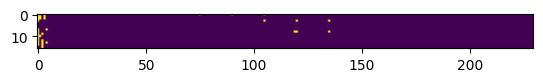

In [21]:
plt.imshow((rl_action_probs - env_aciton_probs).abs() > 1e-3)

In [22]:
(rl_action_probs - env_aciton_probs).abs() < 1e-6

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        ...,
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False,  True, False,  ...,  True,  True,  True]])

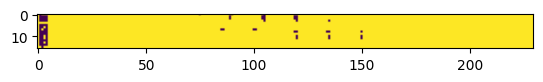

In [23]:
plt.imshow(((rl_action_probs - env_aciton_probs) < 1e-6))

In [24]:
len(rl_action_probs[rl_action_probs != env_aciton_probs])

112

In [ ]:



check_feature('game_step')

In [ ]:
for f in rl_obs.keys():
    print(f, check_feature(f))

In [ ]:
rl_agent_output.shape

In [ ]:
rl_agent.prev_model_action['units_action']

In [ ]:
actions['units_action'].shape

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5)) 


axes[0].imshow(rl_agent.mm.team_point_mass.T)
axes[1].imshow(lux_env.mms[0].team_point_mass.T)